Importuri & configurări

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import shap

from datetime import datetime
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score,
    precision_recall_fscore_support, accuracy_score, brier_score_loss
)
from imblearn.over_sampling import SMOTE

import joblib
from joblib import dump

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.rcParams["figure.dpi"] = 120


Încărcarea datelor

In [ ]:
from google.colab import files

uploaded = files.upload()
if not uploaded:
    raise RuntimeError("Nu s-a încărcat niciun fișier. Re-rulează și selectează 'diabetes.csv'.")

csv_file = list(uploaded.keys())[0]
print(f"\nFișier încărcat: {csv_file}\n")

df = pd.read_csv(csv_file)
print("Dimensiune dataset:", df.shape)
df.head()


Saving diabetes.csv to diabetes.csv

Fișier încărcat: diabetes.csv

Dimensiune dataset: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Info & statistici rapide

In [ ]:
print("Tipuri de date și non-null counts:")
display(df.info())

print("\nStatistici descriptive:")
display(df.describe())

suspect_cols = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
print("\nZero-uri suspecte:")
for c in suspect_cols:
    if c in df.columns:
        print(f" - {c}: {(df[c]==0).sum()}")

print("\nDistribuția Outcome:")
display(df['Outcome'].value_counts().to_frame('count'))


Tipuri de date și non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


None


Statistici descriptive:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000



Zero-uri suspecte:
 - Glucose: 5
 - BloodPressure: 35
 - SkinThickness: 227
 - Insulin: 374
 - BMI: 11

Distribuția Outcome:


,count
Outcome,
0,500
1,268


Zero→NaN (col. clinice)

In [ ]:
cols_with_zeros = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
df_marked = df.copy()
df_marked[cols_with_zeros] = df_marked[cols_with_zeros].replace(0, np.nan)
df_marked.isna().sum()

,0
Pregnancies,0
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11
DiabetesPedigreeFunction,0
Age,0
Outcome,0


Separare features/target + split train/test

In [ ]:
X = df_marked.drop(columns=["Outcome"])
y = df_marked["Outcome"].astype(int)
feature_names = X.columns.tolist()

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)
X_train_raw.shape, X_test_raw.shape, y_train.mean(), y_test.mean()


((614, 8),
 (154, 8),
 np.float64(0.3485342019543974),
 np.float64(0.35064935064935066))

Imputare + Scalare (fit pe train, apply pe test)

In [ ]:
imputer = SimpleImputer(strategy="median")
scaler  = StandardScaler()

X_train_imp = imputer.fit_transform(X_train_raw)
X_test_imp  = imputer.transform(X_test_raw)

X_train_scl = scaler.fit_transform(X_train_imp)
X_test_scl  = scaler.transform(X_test_imp)


SMOTE pe train (echilibrare pentru variantele îmbunătățite)

In [ ]:
smote = SMOTE(random_state=RANDOM_STATE)
X_train_tr, y_train_tr = smote.fit_resample(X_train_scl, y_train)

print("Distribuție înainte SMOTE:", np.bincount(y_train))
print("Distribuție după SMOTE   :", np.bincount(y_train_tr))


Distribuție înainte SMOTE: [400 214]
Distribuție după SMOTE   : [400 400]


Utilitare (metrice & grafice comparative)

In [ ]:
def eval_binary(y_true, proba, threshold=0.5, title=""):
    pred = (proba >= threshold).astype(int)
    acc = accuracy_score(y_true, pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, pred, average="binary", zero_division=0)
    auc = roc_auc_score(y_true, proba)
    print(f"{title}\nAccuracy={acc:.4f}  Precision={prec:.4f}  Recall={rec:.4f}  F1={f1:.4f}  AUC={auc:.4f}")
    print(classification_report(y_true, pred, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y_true, pred))
    return {"acc":acc, "prec":prec, "rec":rec, "f1":f1, "auc":auc}

def plot_compare_roc_pr(y_true, proba_dict, title_suffix=""):
    # ROC
    plt.figure(figsize=(6,5))
    for name, proba in proba_dict.items():
        fpr, tpr, _ = roc_curve(y_true, proba)
        auc = roc_auc_score(y_true, proba)
        plt.plot(fpr, tpr, linewidth=2, label=f"{name} (AUC={auc:.3f})")
    plt.plot([0,1],[0,1],'--', label="Aleator")
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"ROC — {title_suffix}".strip(" —"))
    plt.legend(loc="lower right"); plt.grid(alpha=0.3); plt.show()

    # PR
    plt.figure(figsize=(6,5))
    baseline = y_true.mean()
    for name, proba in proba_dict.items():
        prec, rec, _ = precision_recall_curve(y_true, proba)
        ap = average_precision_score(y_true, proba)
        plt.plot(rec, prec, linewidth=2, label=f"{name} (AP={ap:.3f})")
    plt.plot([0,1],[baseline, baseline],'--', label=f"Frac. pozitivi = {baseline:.2f}")
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"Precision–Recall — {title_suffix}".strip(" —"))
    plt.legend(loc="lower left"); plt.grid(alpha=0.3); plt.show()


Logistic Regression baseline (fără SMOTE; doar class_weight balanced)

In [ ]:
lr_base = LogisticRegression(max_iter=2000, solver="liblinear",
                             class_weight="balanced", random_state=RANDOM_STATE)
lr_base.fit(X_train_scl, y_train)
proba_lr_base = lr_base.predict_proba(X_test_scl)[:, 1]

print("=== Logistic Regression (baseline) — thr=0.5 ===")
m_lr_base = eval_binary(y_test, proba_lr_base, 0.5, "LR Baseline")


=== Logistic Regression (baseline) — thr=0.5 ===
LR Baseline
Accuracy=0.7338  Precision=0.6032  Recall=0.7037  F1=0.6496  AUC=0.8126
              precision    recall  f1-score   support

           0     0.8242    0.7500    0.7853       100
           1     0.6032    0.7037    0.6496        54

    accuracy                         0.7338       154
   macro avg     0.7137    0.7269    0.7175       154
weighted avg     0.7467    0.7338    0.7377       154

Confusion matrix:
 [[75 25]
 [16 38]]


Calibrare + Brier + ECE (pentru baseline)

Brier score (TEST): 0.1814
ECE (quantile bins): 0.1095



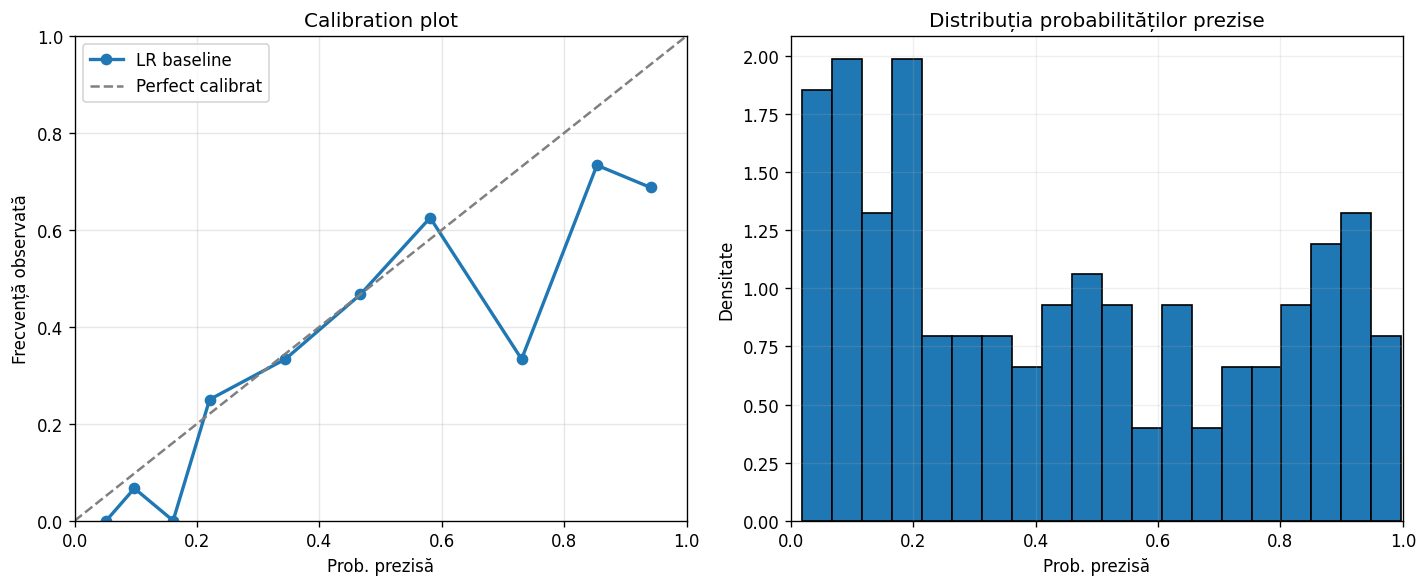

In [ ]:
prob_true, prob_pred = calibration_curve(y_test, proba_lr_base, n_bins=10, strategy="quantile")
brier = brier_score_loss(y_test, proba_lr_base)

# ECE pe aceleași bin-uri (quantile)
q = np.linspace(0, 1, 11)
edges = np.quantile(proba_lr_base, q)
bin_idx = np.digitize(proba_lr_base, edges[1:-1], right=True)  # 0..9

ece_terms = []
for b in range(10):
    m = (bin_idx == b)
    if m.sum() == 0:
        continue
    conf = proba_lr_base[m].mean()
    acc  = y_test[m].mean()
    ece_terms.append(m.mean() * abs(acc - conf))
ece = float(np.sum(ece_terms))

print(f"Brier score (TEST): {brier:.4f}")
print(f"ECE (quantile bins): {ece:.4f}\n")

fig, axes = plt.subplots(1, 2, figsize=(12,5))
# Calibration plot
axes[0].plot(prob_pred, prob_true, marker='o', linewidth=2, label="LR baseline")
axes[0].plot([0,1],[0,1],'--', color='gray', label="Perfect calibrat")
axes[0].set_xlim(0,1); axes[0].set_ylim(0,1)
axes[0].set_xlabel("Prob. prezisă"); axes[0].set_ylabel("Frecvență observată")
axes[0].set_title("Calibration plot"); axes[0].legend(loc="upper left"); axes[0].grid(alpha=0.3)

# Histogramă (densitate)
axes[1].hist(proba_lr_base, bins=20, edgecolor='k', density=True)
axes[1].set_xlim(0,1); axes[1].set_xlabel("Prob. prezisă"); axes[1].set_ylabel("Densitate")
axes[1].set_title("Distribuția probabilităților prezise"); axes[1].grid(alpha=0.2)

plt.tight_layout(); plt.show()


Coeficienți & „odds ratios” (baseline)

,coeficient,odds_ratio = exp(coef),efect
Glucose,1.1830,3.2640,crește riscul de diabet
BMI,0.7094,2.0327,crește riscul de diabet
Pregnancies,0.3725,1.4514,crește riscul de diabet
DiabetesPedigreeFunction,0.2875,1.3332,crește riscul de diabet
Age,0.1864,1.2049,crește riscul de diabet
Insulin,-0.0447,0.9562,scade riscul de diabet
BloodPressure,-0.0148,0.9853,scade riscul de diabet
SkinThickness,0.0135,1.0136,crește riscul de diabet


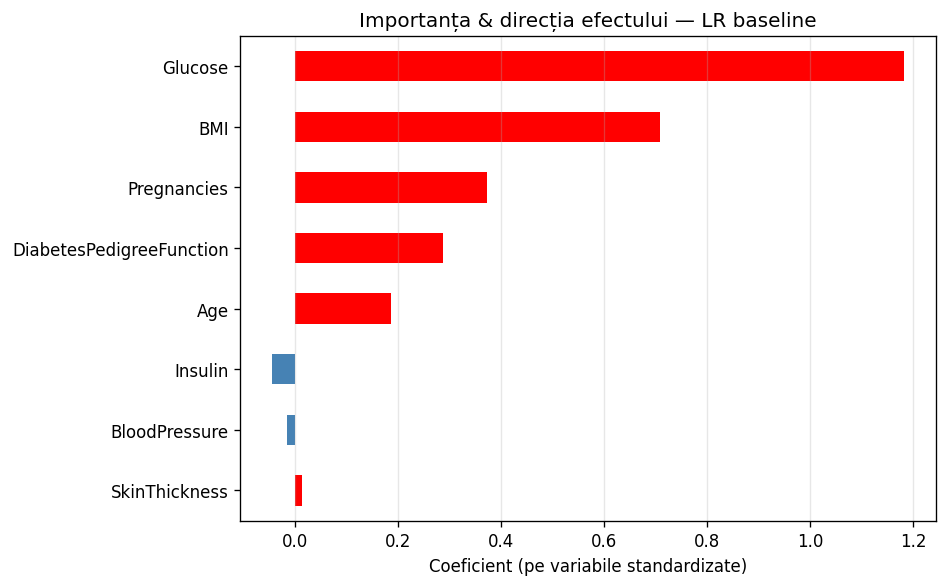

In [ ]:
coefs = pd.Series(lr_base.coef_.ravel(), index=feature_names)
odds  = np.exp(coefs)

interpretare = (
    pd.DataFrame({"coeficient": coefs, "odds_ratio = exp(coef)": odds})
    .reindex(coefs.abs().sort_values(ascending=False).index)
    .round(4)
)
interpretare["efect"] = np.where(interpretare["coeficient"] > 0,
                                 "crește riscul de diabet",
                                 "scade riscul de diabet")
display(interpretare)

plt.figure(figsize=(8,5))
colors = ['red' if c > 0 else 'steelblue' for c in interpretare["coeficient"].iloc[::-1]]
interpretare["coeficient"].iloc[::-1].plot(kind="barh", color=colors)
plt.xlabel("Coeficient (pe variabile standardizate)")
plt.title("Importanța & direcția efectului — LR baseline")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()


LR îmbunătățit: SMOTE + Polynomial (deg=2) + GridSearch

In [ ]:
# 1) PolynomialFeatures (deg=2) pe train balansat
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_tr)
X_test_poly  = poly.transform(X_test_scl)

print("Dimensiune inițială:", X_train_tr.shape, "-> după poly(deg=2):", X_train_poly.shape)

# 2) GridSearch pe C & penalty
param_grid = {"penalty": ["l2","l1"], "C": [0.01, 0.1, 0.5, 1, 2, 5, 10, 50]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid_lr_poly = GridSearchCV(
    LogisticRegression(solver="liblinear", max_iter=3000, random_state=RANDOM_STATE),
    param_grid=param_grid, scoring="accuracy", cv=cv, n_jobs=-1
)
grid_lr_poly.fit(X_train_poly, y_train_tr)
print("Best params:", grid_lr_poly.best_params_, "CV acc:", round(grid_lr_poly.best_score_,4))

# 3) Model final + evaluare
lr_poly = grid_lr_poly.best_estimator_
lr_poly.fit(X_train_poly, y_train_tr)
proba_lr_poly = lr_poly.predict_proba(X_test_poly)[:, 1]

print("=== LR + SMOTE + Poly (thr=0.5) ===")
m_lr_poly = eval_binary(y_test, proba_lr_poly, 0.5, "LR + SMOTE + Poly")


Dimensiune inițială: (800, 8) -> după poly(deg=2): (800, 44)
Best params: {'C': 5, 'penalty': 'l2'} CV acc: 0.7725
=== LR + SMOTE + Poly (thr=0.5) ===
LR + SMOTE + Poly
Accuracy=0.7273  Precision=0.5938  Recall=0.7037  F1=0.6441  AUC=0.8169
              precision    recall  f1-score   support

           0     0.8222    0.7400    0.7789       100
           1     0.5938    0.7037    0.6441        54

    accuracy                         0.7273       154
   macro avg     0.7080    0.7219    0.7115       154
weighted avg     0.7421    0.7273    0.7317       154

Confusion matrix:
 [[74 26]
 [16 38]]


Comparație vizuală ROC & PR (Baseline vs. Poly)

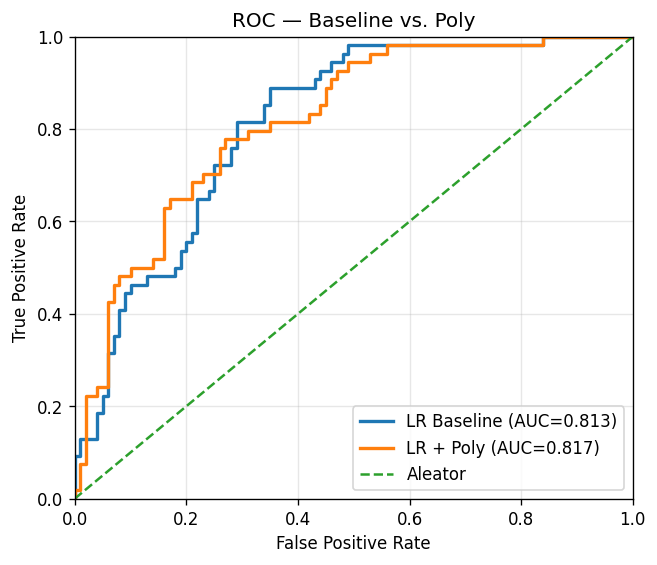

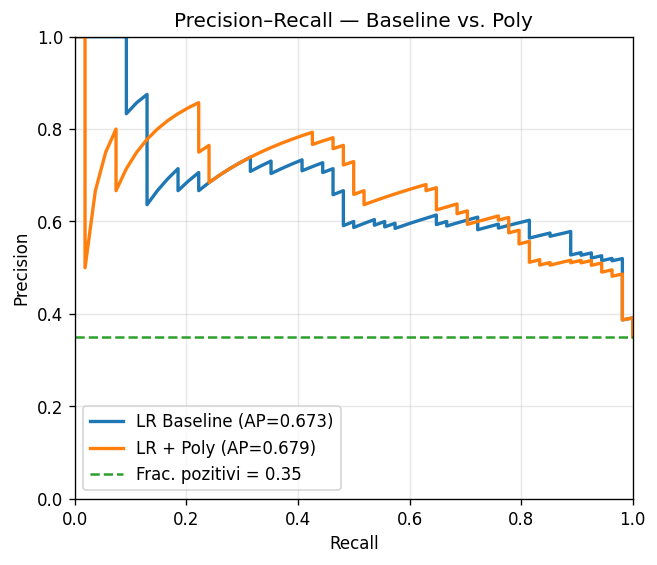

In [ ]:
plot_compare_roc_pr(y_test, {
    "LR Baseline": proba_lr_base,
    "LR + Poly":   proba_lr_poly
}, title_suffix="Baseline vs. Poly")


Comparație numerică (tabel + bar chart)

,Accuracy,Precision,Recall,F1,ROC AUC
LR Baseline,0.7338,0.6032,0.7037,0.6496,0.8126
LR + SMOTE + Poly,0.7273,0.5938,0.7037,0.6441,0.8169


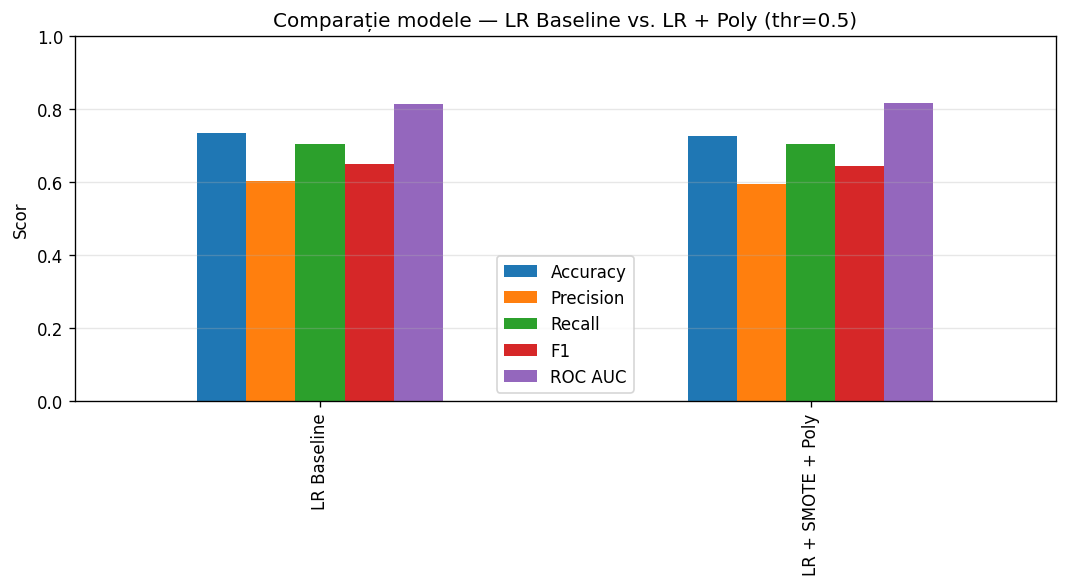

In [ ]:
acc_b  = m_lr_base["acc"];  prec_b = m_lr_base["prec"];  rec_b = m_lr_base["rec"];  f1_b = m_lr_base["f1"];  auc_b = m_lr_base["auc"]
acc_p  = m_lr_poly["acc"];  prec_p = m_lr_poly["prec"];  rec_p = m_lr_poly["rec"];  f1_p = m_lr_poly["f1"];  auc_p = m_lr_poly["auc"]

comparatie = pd.DataFrame({
    "Accuracy":  [acc_b,  acc_p],
    "Precision": [prec_b, prec_p],
    "Recall":    [rec_b,  rec_p],
    "F1":        [f1_b,   f1_p],
    "ROC AUC":   [auc_b,  auc_p],
}, index=["LR Baseline", "LR + SMOTE + Poly"]).round(4)

display(comparatie)

ax = comparatie.plot(kind="bar", figsize=(9,5))
plt.title("Comparație modele — LR Baseline vs. LR + Poly (thr=0.5)")
plt.ylabel("Scor"); plt.ylim(0,1)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout(); plt.show()


Curba Learning Curve (pentru bias/variance)

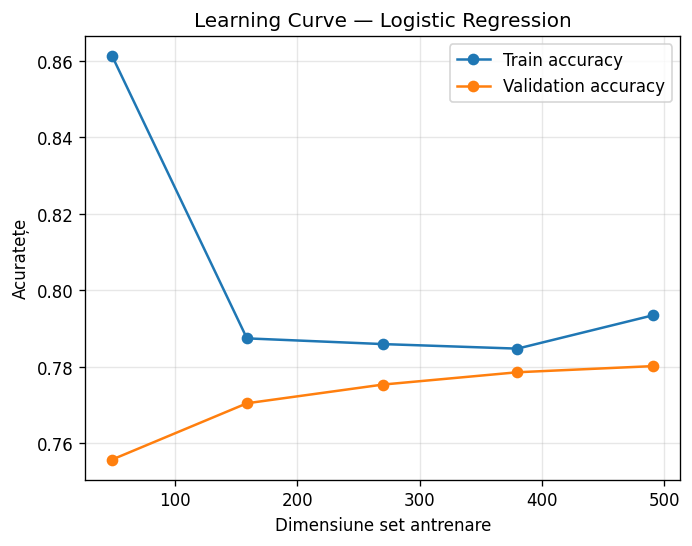

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    LogisticRegression(max_iter=2000, solver="liblinear", random_state=RANDOM_STATE),
    X_train_scl, y_train, cv=5, scoring="accuracy", n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, 'o-', label="Train accuracy")
plt.plot(train_sizes, val_mean, 'o-', label="Validation accuracy")
plt.xlabel("Dimensiune set antrenare")
plt.ylabel("Acuratețe")
plt.title("Learning Curve — Logistic Regression")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Histogramă predictii per clasă

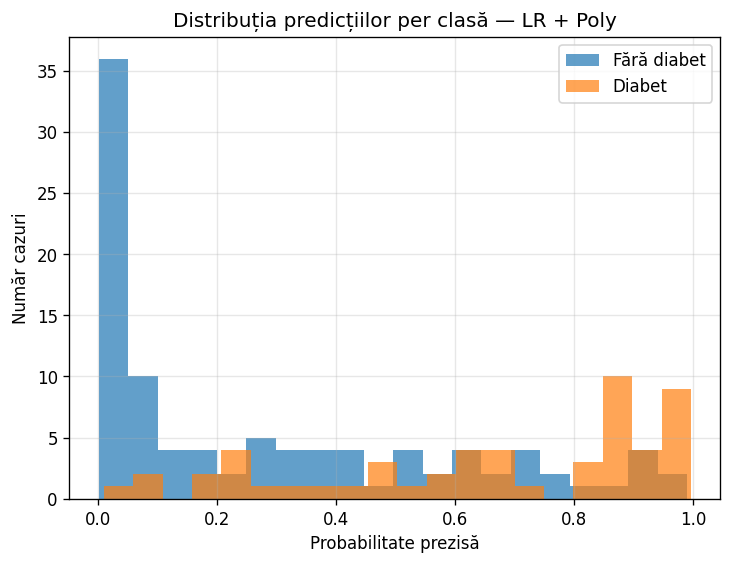

In [ ]:
plt.figure(figsize=(7,5))
plt.hist(proba_lr_poly[y_test==0], bins=20, alpha=0.7, label="Fără diabet")
plt.hist(proba_lr_poly[y_test==1], bins=20, alpha=0.7, label="Diabet")
plt.xlabel("Probabilitate prezisă")
plt.ylabel("Număr cazuri")
plt.title("Distribuția predicțiilor per clasă — LR + Poly")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Prag optim pe valid (max F1) și aplicare pe test

In [ ]:
# split valid din TRAIN original (fără scurgere din TEST)
X_tr_sub, X_val, y_tr_sub, y_val = train_test_split(
    X_train_raw, y_train, test_size=0.2, stratify=y_train, random_state=RANDOM_STATE
)

# preproc pe sub-train
imp_val = SimpleImputer(strategy="median"); sc_val = StandardScaler()
X_tr_sub_imp = imp_val.fit_transform(X_tr_sub); X_val_imp = imp_val.transform(X_val)
X_tr_sub_scl = sc_val.fit_transform(X_tr_sub_imp); X_val_scl = sc_val.transform(X_val_imp)

# SMOTE pe sub-train
sm_val = SMOTE(random_state=RANDOM_STATE)
X_tr_sub_tr, y_tr_sub_tr = sm_val.fit_resample(X_tr_sub_scl, y_tr_sub)

# re-antrenare LR (fără class_weight) pe sub-train echilibrat
logreg_val = LogisticRegression(max_iter=2000, solver="liblinear", random_state=RANDOM_STATE)
logreg_val.fit(X_tr_sub_tr, y_tr_sub_tr)
proba_val = logreg_val.predict_proba(X_val_scl)[:, 1]

# best threshold (max F1)
prec_v, rec_v, thr_v = precision_recall_curve(y_val, proba_val)
f1_v = 2 * (prec_v * rec_v) / (prec_v + rec_v + 1e-12)
ix = int(np.nanargmax(f1_v))
best_threshold = thr_v[ix] if ix < len(thr_v) else 0.5
print(f"Prag optim (max F1) pe VALIDARE: {best_threshold:.4f} | Precision={prec_v[ix]:.4f} Recall={rec_v[ix]:.4f} F1={f1_v[ix]:.4f}")

# aplicăm pragul pe modelele deja evaluate (ex. LR + Poly)
pred_test_opt_poly = (proba_lr_poly >= best_threshold).astype(int)
print("\nEvaluare LR + Poly cu pragul optim:")
print(classification_report(y_test, pred_test_opt_poly, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, pred_test_opt_poly))


Prag optim (max F1) pe VALIDARE: 0.6266 | Precision=0.7692 Recall=0.6977 F1=0.7317

Evaluare LR + Poly cu pragul optim:
              precision    recall  f1-score   support

           0     0.8077    0.8400    0.8235       100
           1     0.6800    0.6296    0.6538        54

    accuracy                         0.7662       154
   macro avg     0.7438    0.7348    0.7387       154
weighted avg     0.7629    0.7662    0.7640       154

Confusion matrix:
 [[84 16]
 [20 34]]


SHAP values

/tmp/ipython-input-282681.py:27: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


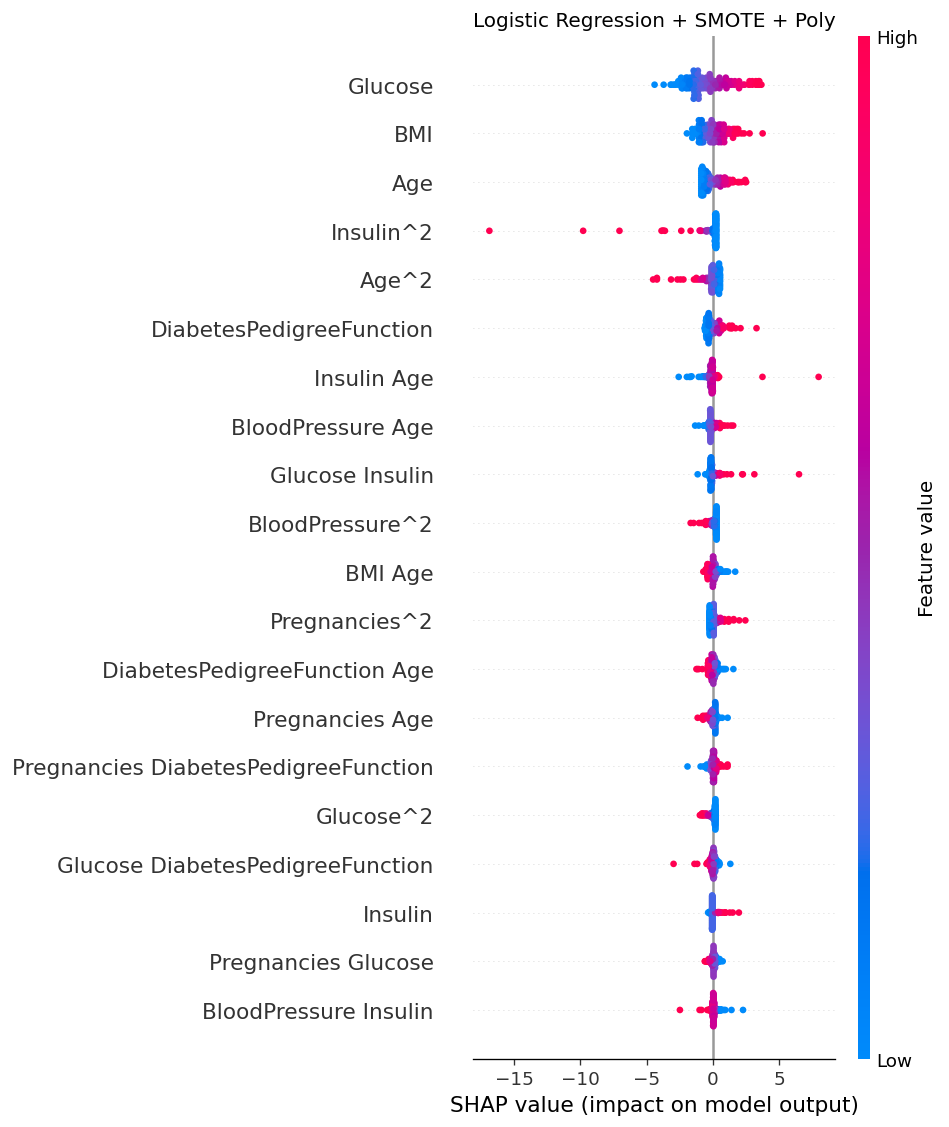

In [ ]:
# Inițializare SHAP
shap.initjs()

# Alegem un background din datele de antrenare în spațiul POLINOMIAL
bg_size = min(200, X_train_poly.shape[0])   # de ex. primele 200 probe
background_lr = X_train_poly[:bg_size]

# LinearExplainer pentru modelul optimizat LR + SMOTE + Poly
explainer_lr_poly = shap.LinearExplainer(lr_poly, background_lr)

# Alegem un subset din test (tot în spațiul POLINOMIAL)
n_samples = min(200, X_test_poly.shape[0])
X_test_poly_sample = X_test_poly[:n_samples]

# Calculăm valorile SHAP
shap_values_lr_poly = explainer_lr_poly.shap_values(X_test_poly_sample)

# Pentru unele versiuni de shap, rezultatul este listă [clasa0, clasa1]
if isinstance(shap_values_lr_poly, list):
    shap_values_lr_poly_plot = shap_values_lr_poly[1]   # clasa 1 = diabet
else:
    shap_values_lr_poly_plot = shap_values_lr_poly

feature_names_poly = poly.get_feature_names_out(feature_names)

# Summary plot SHAP cu nume de feature și titlu clar
shap.summary_plot(
    shap_values_lr_poly_plot,
    X_test_poly_sample,
    feature_names=feature_names_poly,
    show=False
)

plt.title("Logistic Regression + SMOTE + Poly")
plt.tight_layout()
plt.show()
